First step is to, import the relevant libraries which will allow us to perform the machine learning workflow for road accident prediction in london

* `pandas` for data import and handling;
* `matplotlib`;
* `numpy`;
* `sklearn`;
* `xgboost` for XGBoost models.
* `rfpimp` for permutation feature importance.

**Lets run the script below to get started.**

In [118]:
# 📦 Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Geo-related libraries (only if needed in later steps)
import geopandas as gpd
import folium
from folium import Choropleth, Popup, Tooltip

# ⚙️ Machine Learning and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

# 🚀 XGBoost (for gradient boosting models)
import xgboost
from xgboost import XGBRegressor, XGBClassifier

# 🧪 Version check and display settings
def check_versions():
    """
    Function to check the version of key libraries.
    This helps identify potential version mismatches.
    """
    print("Libraries imported successfully.")
    print(f"pandas version: {pd.__version__}")
    print(f"matplotlib version: {plt.matplotlib.__version__}")  # Corrected for matplotlib version
    print(f"xgboost version: {xgboost.__version__}")
    print(f"scikit-learn version: {sklearn.__version__}")

# Configuration settings for pandas display options
def configure_display():
    """
    Function to configure pandas display options for better readability.
    """
    pd.set_option('display.max_columns', None)  # Display all columns
    pd.set_option('display.width', None)        # Auto-width for display
    pd.options.display.float_format = '{:40,.4f}'.format
    plt.style.use('ggplot')                     # Consistent plotting style

# Call functions for setup
check_versions()  # Print versions of libraries
configure_display()  # Configure pandas and matplotlib settings

# ✅ Confirm successful setup
print("Setup completed successfully. Ready for data manipulation and model training.")


Libraries imported successfully.
pandas version: 2.2.3
matplotlib version: 3.9.2
xgboost version: 3.0.0
scikit-learn version: 1.6.1
Setup completed successfully. Ready for data manipulation and model training.


### Description for Accident Prediction Dataset

The Data size and quality is very important to be able to allow us carr out machine learning models which is why I used the daily counts of road traffic accidents in London, along with environmental, temporal, and spatial information. The goal here is to predict the likelihood of accidents occurrence based on different variables such as weather conditions, time of the day, road type, location of accident, and other contributing factors. This dataset has been processed to facilitate analysis for supervised machine learning tasks.

Here is a list of the variables in the dataset:

- **Daily Count of Accidents**: The total number of accidents occurring per day. This count is used as the response in the regression task.
- **Indicator of Severity**: The most common severity of accidents per day (e.g., fatal, serious, or slight).
- **Indicator of Season**: Either spring, summer, fall, or winter, derived from the date.
- **Average Accident Timing**: The mean hour of accidents on a given day, representing temporal patterns.
- **Indicator Whether the Day Was a Weekend**: A binary indicator to flag weekends versus weekdays.
- **Weather Conditions**: Categories describing weather conditions during the day, such as:
  - **'GOOD'**: Fine no high winds, clear, or few clouds.
  - **'FOG/MIST'**: Foggy or misty weather.
  - **'RAIN/SNOW/STORM'**: Conditions such as rain, snow, or storms.
- **Spatial Features**: Longitude and latitude aggregated into clusters to identify accident-prone areas in London.
- **Road Design**: Features like `road type or junction information that describe the infrastructure associated with accidents.

---

### Methodology

We will use the Pandas package to load and explore this dataset:

1. **Load the Dataset**:
   Import the dataset and convert columns like `date` and `time` into formats suitable for analysis.

2. **Inspect the Data**:
   Explore the structure and calculate summary statistics for all attributes to identify trends and issues.

3. **Aggregate Features**:
   Process the data to group accidents by day and calculate key statistics, such as:
   - Accident counts.
   - Severity distribution.
   - Spatial clustering for accident-prone zones.

4. **Create New Features**:
   Extract temporal and environmental features such as `season`, `day_of_week`, and `is_weekend`, alongside spatial clusters derived from longitude and latitude.

---

### Application and Goal

The processed dataset will enable predictive modeling tasks to:
- Determine the likelihood of accidents occurring on specific days based on contributing factors like weather, timing, and road design.
- Explore spatial patterns to identify high-risk areas in London.
- Analyze trends in accident severity and timing to assist with targeted interventions.

This analysis prepares the dataset for regression and classification tasks, aiming to uncover actionable insights into road safety and accident prediction models.


In [119]:
# 📁 File paths to the road accident dataset and shapefiles
road_accident_path = r'C:\Users\Idris\OneDrive - University College London\Documents\CASA 24_25\TERM 2\Data Science for Spatial Systems\Assesement\Data\Road Safety\Sorted\dft-road-casualty-statistics-collision-2023.csv'
lsoa_shapefile_path = r'C:\Users\Idris\OneDrive - University College London\Documents\CASA 24_25\TERM 2\Data Science for Spatial Systems\Assesement\Data\Shapefiles\statistical-gis-boundaries-london\statistical-gis-boundaries-london\ESRI\LSOA_2011_London_gen_MHW.shp'
road_shapefile_path = r"C:\Users\Idris\OneDrive - University College London\Documents\CASA 24_25\TERM 2\Data Science for Spatial Systems\Assesement\Accident_Prediction\Data\Shapefiles\Major_Road_Network_2018_Open_Roads\Major_Road_Network_2018_Open_Roads.shp"

# 📊 Load road accident dataset with date parsing
try:
    data = pd.read_csv(road_accident_path, parse_dates=['date'], dayfirst=True)  # Assuming day-first format
    print("✅ Road accident dataset loaded successfully.")
except FileNotFoundError:
    print(f"❌ The file at {road_accident_path} was not found.")
except ValueError as e:
    print(f"❌ Error while parsing the dates or loading the dataset: {e}")

# 👀 Preview the road accident dataset
if 'data' in locals():  # Check if the dataset was successfully loaded
    print("✅ First few rows of the road accident dataset:")
    print(data.head())
else:
    print("❌ Road accident dataset could not be loaded. Please check the file path or format.")

# 🌍 Load LSOA shapefile using GeoPandas
try:
    gdf_lsoa = gpd.read_file(lsoa_shapefile_path)
    print("✅ LSOA shapefile loaded successfully.")
except Exception as e:
    print(f"❌ Error loading LSOA shapefile: {e}")

# 👀 Preview the LSOA shapefile data
if 'gdf_lsoa' in locals():  # Check if the shapefile was successfully loaded
    print("✅ First few rows of the LSOA shapefile data:")
    print(gdf_lsoa.head())
else:
    print("❌ LSOA shapefile could not be loaded. Please check the file path or format.")

# 🌍 Load Major Road Network shapefile using GeoPandas
try:
    gdf_roads = gpd.read_file(road_shapefile_path)
    print("✅ Major Road Network shapefile loaded successfully.")
except Exception as e:
    print(f"❌ Error loading Major Road Network shapefile: {e}")

# 👀 Preview the Road shapefile data
if 'gdf_roads' in locals():  # Check if the shapefile was successfully loaded
    print("✅ First few rows of the Major Road Network shapefile data:")
    print(gdf_roads.head())
else:
    print("❌ Major Road Network shapefile could not be loaded. Please check the file path or format.")


C:\Users\Idris\AppData\Local\Temp\ipykernel_9144\756990542.py:8: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(road_accident_path, parse_dates=['date'], dayfirst=True)  # Assuming day-first format


✅ Road accident dataset loaded successfully.
✅ First few rows of the road accident dataset:
  accident_index  accident_year accident_reference  \
0  2023010419171           2023           10419171   
1  2023010419183           2023           10419183   
2  2023010419189           2023           10419189   
3  2023010419191           2023           10419191   
4  2023010419192           2023           10419192   

                     location_easting_osgr  \
0                             525,060.0000   
1                             535,463.0000   
2                             508,702.0000   
3                             520,341.0000   
4                             527,255.0000   

                    location_northing_osgr  \
0                             170,416.0000   
1                             198,745.0000   
2                             177,696.0000   
3                             190,175.0000   
4                             176,963.0000   

                             

In [120]:
# 🧹 Drop columns only if they're not needed for future spatial joins
columns_to_drop = [
    'accident_reference', 'police_force', 'local_authority_district',
    'local_authority_ons_district', 'local_authority_highway',
    'first_road_class', 'pedestrian_crossing_physical_facilities',
    'pedestrian_crossing_human_control', 'second_road_number',
    'first_road_number', 'carriageway_hazards', 'special_conditions_at_site',
    'trunk_road_flag', 'second_road_class', 'did_police_officer_attend_scene_of_accident',
    'enhanced_severity_collision'
]

# Keep coordinates until spatial joins are complete
if 'longitude' in data.columns and 'latitude' in data.columns:
    # You're likely safe to drop OSGR (eastings/northings) if not needed
    columns_to_drop.append('location_easting_osgr')
    columns_to_drop.append('location_northing_osgr')

# Drop only columns that exist in the data
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

# ℹ️ Check updated dataset info
print(f"\n✅ Dataset shape after dropping columns: {data.shape}")
print(data.info())



✅ Dataset shape after dropping columns: (104258, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104258 entries, 0 to 104257
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   accident_index             104258 non-null  object        
 1   accident_year              104258 non-null  int64         
 2   longitude                  104246 non-null  float64       
 3   latitude                   104246 non-null  float64       
 4   accident_severity          104258 non-null  int64         
 5   number_of_vehicles         104258 non-null  int64         
 6   number_of_casualties       104258 non-null  int64         
 7   date                       104258 non-null  datetime64[ns]
 8   day_of_week                104258 non-null  int64         
 9   time                       104258 non-null  object        
 10  road_type                  104258 non-null  int64         
 11

In [109]:
# print a few rows of this dataset
data.head()


,accident_index,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,road_type,speed_limit,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,lsoa_of_accident_location
0,2023010419171,2023,-0.2029,51.4190,3,1,1,01/01/2023,1,01:24,2,20,9,4,4,8,2,1,E01003383
1,2023010419183,2023,-0.0425,51.6712,3,3,2,01/01/2023,1,02:25,6,30,3,4,4,1,1,1,E01001547
2,2023010419189,2023,-0.4358,51.4878,3,2,1,01/01/2023,1,03:50,1,30,1,4,4,1,1,1,E01002448
3,2023010419191,2023,-0.2640,51.5976,3,2,1,01/01/2023,1,02:13,6,30,3,4,4,9,1,1,E01000129
4,2023010419192,2023,-0.1690,51.4773,3,2,1,01/01/2023,1,01:42,6,30,8,4,4,1,1,1,E01004583


Missing data can distort your analysis. This chunk identifies columns with missing values and removes rows containing these values. Alternatively, you can use imputation (e.g., filling missing values with the mean/median).

In [110]:
# 🔍 Check for missing values
missing_values = data.isnull().sum()

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Display results
if not missing_values.empty:
    print("⚠️ Columns with missing values:")
    print(missing_values)
else:
    print("✅ No missing values detected in the dataset.")


⚠️ Columns with missing values:
longitude    12
latitude     12
dtype: int64


In [111]:
# 🌍 Flag and fill missing spatial values (longitude & latitude)
data['longitude_missing'] = data['longitude'].isnull().astype(int)
data['latitude_missing'] = data['latitude'].isnull().astype(int)

# Fill missing values with the mean (can be replaced with a better strategy later)
data['longitude'].fillna(data['longitude'].mean(), inplace=True)
data['latitude'].fillna(data['latitude'].mean(), inplace=True)

# Confirm no missing spatial values remain
print("✅ Missing values after handling (longitude & latitude):")
print(data[['longitude', 'latitude']].isnull().sum())


✅ Missing values after handling (longitude & latitude):
longitude    0
latitude     0
dtype: int64


C:\Users\Idris\AppData\Local\Temp\ipykernel_9144\3979761064.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['longitude'].fillna(data['longitude'].mean(), inplace=True)
C:\Users\Idris\AppData\Local\Temp\ipykernel_9144\3979761064.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [112]:
# 🌅 Ensure 'day_of_week' is numeric and handle unexpected values
data['day_of_week'] = pd.to_numeric(data['day_of_week'], errors='coerce')

# Create a weekend indicator: 1 = weekend (Saturday=7, Sunday=1), 0 = weekday
data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x in [1, 7] else 0)

# Optional: map numeric day to actual names (for better readability or visualization)
day_map = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}
data['day_name'] = data['day_of_week'].map(day_map)

# Verify the new 'day_of_week' related features
print(data[['day_of_week', 'day_name', 'weekend']].head(10))


   day_of_week day_name  weekend
0            1   Sunday        1
1            1   Sunday        1
2            1   Sunday        1
3            1   Sunday        1
4            1   Sunday        1
5            1   Sunday        1
6            1   Sunday        1
7            1   Sunday        1
8            1   Sunday        1
9            1   Sunday        1


In [12]:
data.head()

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,road_type,speed_limit,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,lsoa_of_accident_location,longitude_missing,latitude_missing,weekend,day_name
0,2023010419171,2023,-0.2029,51.4190,3,1,1,01/01/2023,1,01:24,2,20,9,4,4,8,2,1,E01003383,0,0,1,Sunday
1,2023010419183,2023,-0.0425,51.6712,3,3,2,01/01/2023,1,02:25,6,30,3,4,4,1,1,1,E01001547,0,0,1,Sunday
2,2023010419189,2023,-0.4358,51.4878,3,2,1,01/01/2023,1,03:50,1,30,1,4,4,1,1,1,E01002448,0,0,1,Sunday
3,2023010419191,2023,-0.2640,51.5976,3,2,1,01/01/2023,1,02:13,6,30,3,4,4,9,1,1,E01000129,0,0,1,Sunday
4,2023010419192,2023,-0.1690,51.4773,3,2,1,01/01/2023,1,01:42,6,30,8,4,4,1,1,1,E01004583,0,0,1,Sunday


In [38]:
# ⏰ Convert 'time' column to datetime format safely
data['time_parsed'] = pd.to_datetime(data['time'], format='%H:%M', errors='coerce')

# Extract the hour, ensuring NaT is handled gracefully
data['hour'] = data['time_parsed'].dt.hour

# Define function to categorize time of the day
def categorize_time(hour):
    if pd.isnull(hour):  # Handle missing or invalid time
        return 'Unknown'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour <= 23:
        return 'Evening'
    else:
        return 'Midnight'  # 0 <= hour < 6

# Apply the categorization function to each row
data['time_bucket'] = data['hour'].apply(categorize_time)

# Preview the results
print(data[['time', 'hour', 'time_bucket']].head())


    time  hour time_bucket
0  01:24     1    Midnight
1  02:25     2    Midnight
2  03:50     3    Midnight
3  02:13     2    Midnight
4  01:42     1    Midnight


In [14]:
data.head()

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,road_type,speed_limit,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,lsoa_of_accident_location,longitude_missing,latitude_missing,weekend,day_name,time_parsed,hour,time_bucket
0,2023010419171,2023,-0.2029,51.4190,3,1,1,01/01/2023,1,01:24,2,20,9,4,4,8,2,1,E01003383,0,0,1,Sunday,1900-01-01 01:24:00,1,Midnight
1,2023010419183,2023,-0.0425,51.6712,3,3,2,01/01/2023,1,02:25,6,30,3,4,4,1,1,1,E01001547,0,0,1,Sunday,1900-01-01 02:25:00,2,Midnight
2,2023010419189,2023,-0.4358,51.4878,3,2,1,01/01/2023,1,03:50,1,30,1,4,4,1,1,1,E01002448,0,0,1,Sunday,1900-01-01 03:50:00,3,Midnight
3,2023010419191,2023,-0.2640,51.5976,3,2,1,01/01/2023,1,02:13,6,30,3,4,4,9,1,1,E01000129,0,0,1,Sunday,1900-01-01 02:13:00,2,Midnight
4,2023010419192,2023,-0.1690,51.4773,3,2,1,01/01/2023,1,01:42,6,30,8,4,4,1,1,1,E01004583,0,0,1,Sunday,1900-01-01 01:42:00,1,Midnight


In [39]:
# ⏳ Convert 'time_bucket' to ordered categorical type (optional)
from pandas.api.types import CategoricalDtype

# Define the order of time categories
time_order = CategoricalDtype(['Midnight', 'Morning', 'Afternoon', 'Evening', 'Unknown'], ordered=True)

# Apply the ordered categorical type
data['time_bucket'] = data['time_bucket'].astype(time_order)


In [40]:
# 📂 File path to LSOA shapefile
lsoa_shapefile = r'C:\Users\Idris\OneDrive - University College London\Documents\CASA 24_25\TERM 2\Data Science for Spatial Systems\Assesement\Data\Shapefiles\statistical-gis-boundaries-london\statistical-gis-boundaries-london\ESRI\LSOA_2011_London_gen_MHW.shp'

# 📍 Load the London LSOA shapefile using GeoPandas
gdf_lsoa = gpd.read_file(lsoa_shapefile)

# ✅ Preview structure
print("✅ Shapefile loaded. Columns:")
print(gdf_lsoa.columns)

# 🌍 Ensure it's using the correct CRS (Coordinate Reference System)
print("📍 CRS:", gdf_lsoa.crs)

# 🔄 Optionally, reproject to WGS84 (lat/lon) if you're doing web mapping (e.g., with Folium)
if gdf_lsoa.crs != 'EPSG:4326':
    gdf_lsoa = gdf_lsoa.to_crs(epsg=4326)

# 🔍 Preview data
print(gdf_lsoa.head())


✅ Shapefile loaded. Columns:
Index(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')
📍 CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London

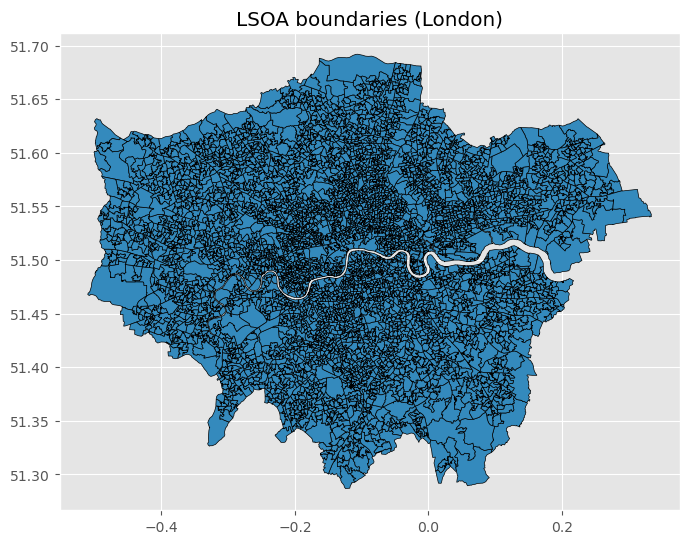

In [41]:
# Plot the LSOA boundaries
gdf_lsoa.plot(figsize=(8, 8), edgecolor='black')
plt.title("LSOA boundaries (London)")
plt.show()


In [42]:
# Merge accident data with LSOA GeoDataFrame on LSOA code
merged_data = data.merge(gdf_lsoa[['LSOA11CD', 'geometry']], 
                         left_on='lsoa_of_accident_location', 
                         right_on='LSOA11CD', 
                         how='left')

# Convert to GeoDataFrame for spatial operations & mapping
merged_gdf = gpd.GeoDataFrame(merged_data, geometry='geometry', crs=gdf_lsoa.crs)

# Verify merge success
print(f"✅ Merged dataset shape: {merged_gdf.shape}")
print("📌 Missing geometries (unmatched LSOA codes):", merged_gdf['geometry'].isnull().sum())

# Preview the first few rows to check
print(merged_gdf[['lsoa_of_accident_location', 'geometry']].head())


✅ Merged dataset shape: (104258, 28)
📌 Missing geometries (unmatched LSOA codes): 81344
  lsoa_of_accident_location                                           geometry
0                 E01003383  POLYGON ((-0.20213 51.41899, -0.20138 51.4174,...
1                 E01001547  POLYGON ((-0.03783 51.67435, -0.03983 51.67207...
2                 E01002448  POLYGON ((-0.435 51.48409, -0.43505 51.48316, ...
3                 E01000129  POLYGON ((-0.265 51.60394, -0.26345 51.60386, ...
4                 E01004583  POLYGON ((-0.16829 51.4787, -0.16745 51.47744,...


In [43]:
# Drop rows with missing geometry (unmatched LSOA codes)
merged_gdf = merged_gdf.dropna(subset=['geometry'])

# Create datetime column by combining date and time columns
merged_gdf['datetime'] = pd.to_datetime(
    merged_gdf['date'].astype(str) + ' ' + merged_gdf['time'],  # Combine date and time
    format='%Y-%m-%d %H:%M',  # Define the expected datetime format
    errors='coerce'  # Invalid or mismatched formats will be converted to NaT
)


In [47]:
# Combine date and time into a single datetime column
merged_gdf['datetime'] = pd.to_datetime(
    merged_gdf['date'] + ' ' + merged_gdf['time'], 
    format='%d/%m/%Y %H:%M',  # Adjusted format to match the data
    errors='coerce'  # If there are any errors in parsing, they will be set to NaT
)

# Check the result
print(merged_gdf[['datetime']].head())


             datetime
0 2023-01-01 01:24:00
1 2023-01-01 02:25:00
2 2023-01-01 03:50:00
3 2023-01-01 02:13:00
4 2023-01-01 01:42:00


In [21]:
merged_data.head()

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,road_type,speed_limit,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,lsoa_of_accident_location,longitude_missing,latitude_missing,weekend,day_name,time_parsed,hour,time_bucket,LSOA11CD,geometry
0,2023010419171,2023,-0.2029,51.4190,3,1,1,01/01/2023,1,01:24,2,20,9,4,4,8,2,1,E01003383,0,0,1,Sunday,1900-01-01 01:24:00,1,Midnight,E01003383,"POLYGON ((-0.20213 51.41899, -0.20138 51.4174,..."
1,2023010419183,2023,-0.0425,51.6712,3,3,2,01/01/2023,1,02:25,6,30,3,4,4,1,1,1,E01001547,0,0,1,Sunday,1900-01-01 02:25:00,2,Midnight,E01001547,"POLYGON ((-0.03783 51.67435, -0.03983 51.67207..."
2,2023010419189,2023,-0.4358,51.4878,3,2,1,01/01/2023,1,03:50,1,30,1,4,4,1,1,1,E01002448,0,0,1,Sunday,1900-01-01 03:50:00,3,Midnight,E01002448,"POLYGON ((-0.435 51.48409, -0.43505 51.48316, ..."
3,2023010419191,2023,-0.2640,51.5976,3,2,1,01/01/2023,1,02:13,6,30,3,4,4,9,1,1,E01000129,0,0,1,Sunday,1900-01-01 02:13:00,2,Midnight,E01000129,"POLYGON ((-0.265 51.60394, -0.26345 51.60386, ..."
4,2023010419192,2023,-0.1690,51.4773,3,2,1,01/01/2023,1,01:42,6,30,8,4,4,1,1,1,E01004583,0,0,1,Sunday,1900-01-01 01:42:00,1,Midnight,E01004583,"POLYGON ((-0.16829 51.4787, -0.16745 51.47744,..."


In [48]:
from geopandas.tools import sjoin

# Perform a spatial join to assign each accident to its LSOA based on location
accidents_per_lsoa = sjoin(
    merged_gdf,
    gdf_lsoa[['LSOA11CD', 'geometry']],
    how='inner',
    predicate='within'
)

# Count number of accidents per LSOA
lsoa_accident_count = accidents_per_lsoa.groupby('LSOA11CD_right').size().reset_index(name='accident_count')

# Merge accident counts back into the LSOA GeoDataFrame
gdf_lsoa = gdf_lsoa.merge(
    lsoa_accident_count.rename(columns={'LSOA11CD_right': 'LSOA11CD'}),
    on='LSOA11CD',
    how='left'
)

# Replace NaN values (LSOAs with no accidents) with 0
gdf_lsoa['accident_count'] = gdf_lsoa['accident_count'].fillna(0).astype(int)


In [49]:
# Compare accident counts before and after the spatial join
print(f"🗺️ Total accidents after spatial join: {accidents_per_lsoa.shape[0]:,}")
print(f"📊 Total accidents in original dataset: {merged_gdf.shape[0]:,}")


🗺️ Total accidents after spatial join: 22,914
📊 Total accidents in original dataset: 22,914


In [50]:
# 🔍 Check missing values in selected columns
print("🧪 Missing values in key categorical columns:")
print(merged_gdf[['weather_conditions', 'light_conditions', 'road_type']].isnull().sum())

# 🛠️ Handle missing or invalid values
# Replace -1 with NaN and fill with mode (most common value) for weather and light
merged_gdf['weather_conditions'] = (
    merged_gdf['weather_conditions']
    .replace(-1, np.nan)
    .fillna(merged_gdf['weather_conditions'].mode()[0])
)

merged_gdf['light_conditions'] = (
    merged_gdf['light_conditions']
    .replace(-1, np.nan)
    .fillna(merged_gdf['light_conditions'].mode()[0])
)

# Treat -1 in 'road_type' as 'Unknown' (code 9)
merged_gdf['road_type'] = merged_gdf['road_type'].replace(-1, 9)


🧪 Missing values in key categorical columns:
weather_conditions    0
light_conditions      0
road_type             0
dtype: int64


In [51]:
# 🔢 Ordinal encoding for road_type (reflecting relative road complexity)
road_type_mapping = {
    1: 0,   # Roundabout
    2: 1,   # One way street
    3: 2,   # Dual carriageway
    6: 3,   # Single carriageway
    7: 4,   # Slip road
    9: 5,   # Unknown
    12: 6   # One way street/Slip road
}

# Apply ordinal encoding
merged_gdf['road_type_encoded'] = merged_gdf['road_type'].map(road_type_mapping)

# 🎯 One-hot encoding for weather and light conditions
# These are nominal features, so dummy encoding makes sense here
weather_dummies = pd.get_dummies(merged_gdf['weather_conditions'], prefix='weather')
light_dummies = pd.get_dummies(merged_gdf['light_conditions'], prefix='light')

# Combine with the main GeoDataFrame
merged_gdf = pd.concat([merged_gdf, weather_dummies, light_dummies], axis=1)


In [52]:
# 🔄 Merge LSOA-level accident counts into the main GeoDataFrame
merged_gdf = merged_gdf.merge(
    gdf_lsoa[['LSOA11CD', 'accident_count']],
    left_on='lsoa_of_accident_location',
    right_on='LSOA11CD',
    how='left'
)

# ✅ Sanity check: confirm successful merge
print("✅ Columns now in merged_gdf:", merged_gdf.columns.tolist())
print("❗ Rows with missing 'accident_count':", merged_gdf['accident_count'].isnull().sum())


✅ Columns now in merged_gdf: ['accident_index', 'accident_year', 'longitude', 'latitude', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'urban_or_rural_area', 'lsoa_of_accident_location', 'longitude_missing', 'latitude_missing', 'weekend', 'day_name', 'time_parsed', 'hour', 'time_bucket', 'LSOA11CD_x', 'geometry', 'datetime', 'road_type_encoded', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_5', 'weather_6', 'weather_7', 'weather_8', 'weather_9', 'light_1', 'light_4', 'light_5', 'light_6', 'light_7', 'LSOA11CD_y', 'accident_count']
❗ Rows with missing 'accident_count': 0


In [53]:
# ✅ Define features to be used in modeling
# Includes temporal, spatial, road-related, and encoded categorical variables
features = [
    'hour',                    # Hour of the day
    'road_type_encoded',       # Ordinal encoding of road type
    'speed_limit',             # Speed limit at accident location
    'accident_count',          # Number of accidents in the LSOA
    'urban_or_rural_area',     # Urban (1) or Rural (2)
    'weekend',                 # Binary: 1 if weekend, 0 if weekday

    # One-hot encoded weather condition columns (you can adjust based on relevance)
    'weather_1',  # Fine no high winds
    'weather_2',  # Raining no high winds
    'weather_4',  # Fine + high winds
    'weather_5',  # Raining + high winds
    'weather_7',  # Fog or mist
    'weather_8',  # Other
    'weather_9',  # Unknown

    # One-hot encoded light condition columns
    'light_1',    # Daylight
    'light_4',    # Darkness - lights lit
    'light_5',    # Darkness - lights unlit
    'light_6',    # Darkness - no lighting
    'light_7'     # Darkness - lighting unknown
]


In [54]:
# 🎯 Adjust target for SHAP and modeling: Convert accident_severity to 0-based classes
# 0 = Fatal, 1 = Serious, 2 = Slight
merged_gdf['accident_severity'] = merged_gdf['accident_severity'] - 1

# 🏷 Define target and features
target = 'accident_severity'
X = merged_gdf[features]
y = merged_gdf[target]

# 🔀 Split data into training and testing sets (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# 🌲 Initialize and train Random Forest with class weights
# Giving more weight to rare classes (Fatal > Serious > Slight)
model = RandomForestClassifier(
    n_estimators=200,
    class_weight={0: 10.0, 1: 5.0, 2: 1.0},  # Emphasize rarer classes
    random_state=42
)
model.fit(X_train, y_train)

# 📊 Evaluate the model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
print(classification_report(
    y_test, y_pred,
    target_names=['Fatal', 'Serious', 'Slight'],  # Keep original labels for readability
    digits=4
))


              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.1825    0.1924    0.1873      1050
      Slight     0.8496    0.8430    0.8463      5795

    accuracy                         0.7399      6875
   macro avg     0.3440    0.3451    0.3445      6875
weighted avg     0.7440    0.7399    0.7419      6875



🔍 Classification Report:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.1825    0.1924    0.1873      1050
      Slight     0.8496    0.8430    0.8463      5795

    accuracy                         0.7399      6875
   macro avg     0.3440    0.3451    0.3445      6875
weighted avg     0.7440    0.7399    0.7419      6875

📉 Normalized Confusion Matrix:


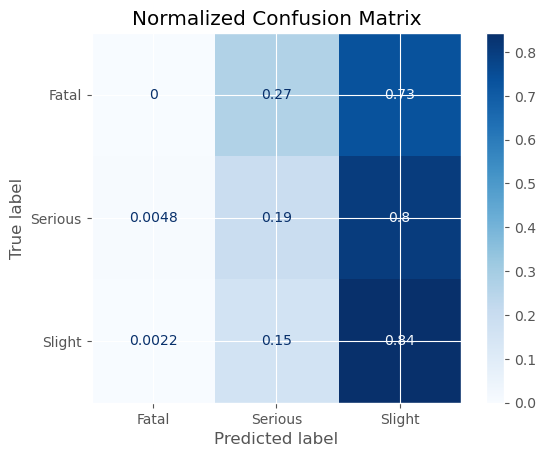

In [55]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# 📊 Classification Report
print("🔍 Classification Report:")
report = classification_report(
    y_test, y_pred,
    target_names=['Fatal', 'Serious', 'Slight'],  # Keep the labels readable
    digits=4
)
print(report)

# 🔄 Confusion Matrix (Normalized)
print("📉 Normalized Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',  # Normalize to show proportions
    display_labels=['Fatal', 'Serious', 'Slight'],  # Keep the labels consistent
    cmap='Blues'  # Color map for the confusion matrix
)
plt.title('Normalized Confusion Matrix')
plt.show()

# Optional: Save the confusion matrix plot
# plt.savefig('confusion_matrix.png')  # Uncomment to save the figure


Fitting 3 folds for each of 324 candidates, totalling 972 fits
🔑 Best Parameters found by GridSearchCV:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
🔍 Classification Report for the Best Model:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.0000    0.0000    0.0000      1050
      Slight     0.8429    1.0000    0.9148      5795

    accuracy                         0.8429      6875
   macro avg     0.2810    0.3333    0.3049      6875
weighted avg     0.7105    0.8429    0.7711      6875

📉 Normalized Confusion Matrix for the Best Model:


c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


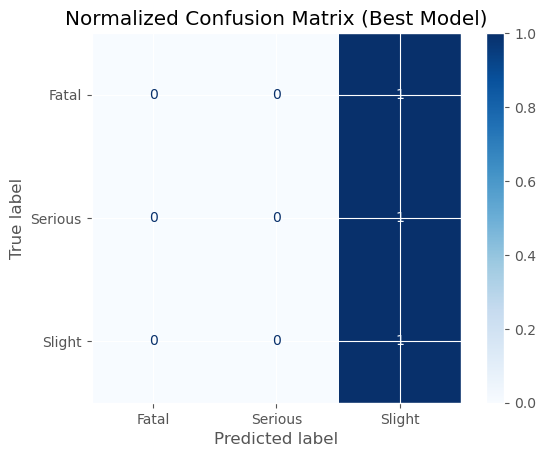

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'class_weight': [{0: 10.0, 1: 5.0, 2: 1.0}, 'balanced', None]  # Class weight to handle class imbalance
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # You can change this to 'roc_auc' if preferred
    verbose=2,  # Display progress
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("🔑 Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)

# 📊 Classification Report for best model
print("🔍 Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# 🔄 Confusion Matrix for the best model (Normalized)
print("📉 Normalized Confusion Matrix for the Best Model:")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best,
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix (Best Model)')
plt.show()


🔍 Classification Report after SMOTE:
              precision    recall  f1-score   support

       Fatal     0.0070    0.0667    0.0127        30
     Serious     0.1797    0.5200    0.2671      1050
      Slight     0.8682    0.5322    0.6599      5795

    accuracy                         0.5283      6875
   macro avg     0.3516    0.3729    0.3132      6875
weighted avg     0.7593    0.5283    0.5971      6875

📉 Normalized Confusion Matrix after SMOTE:


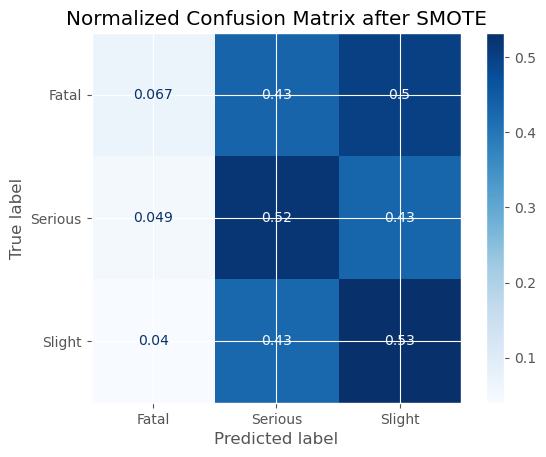

In [58]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define the oversampling method (SMOTE)
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define the model again (or use the best model from GridSearchCV)
model = RandomForestClassifier(
    n_estimators=100, 
    class_weight=None, 
    max_depth=10, 
    min_samples_split=2, 
    min_samples_leaf=4, 
    random_state=42
)

# Create a pipeline with SMOTE and the RandomForest model
pipeline = Pipeline(steps=[('smote', smote), ('model', model)])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict with the oversampled model
y_pred_smote = pipeline.predict(X_test)

# 📊 Classification Report for the model after applying SMOTE
print("🔍 Classification Report after SMOTE:")
print(classification_report(y_test, y_pred_smote, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# 🔄 Confusion Matrix for the model after SMOTE (Normalized)
print("📉 Normalized Confusion Matrix after SMOTE:")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_smote, 
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix after SMOTE')
plt.show()


📊 Cross-validation results (Accuracy): [0.84289767 0.84289767 0.84289767 0.84289767 0.84286338]
📈 Mean CV Accuracy: 0.8429
Fitting 5 folds for each of 162 candidates, totalling 810 fits
🔑 Best Hyperparameters found by GridSearchCV:
{'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🔍 Classification Report for Best Model:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.0000    0.0000    0.0000      1050
      Slight     0.8429    1.0000    0.9148      5795

    accuracy                         0.8429      6875
   macro avg     0.2810    0.3333    0.3049      6875
weighted avg     0.7105    0.8429    0.7711      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


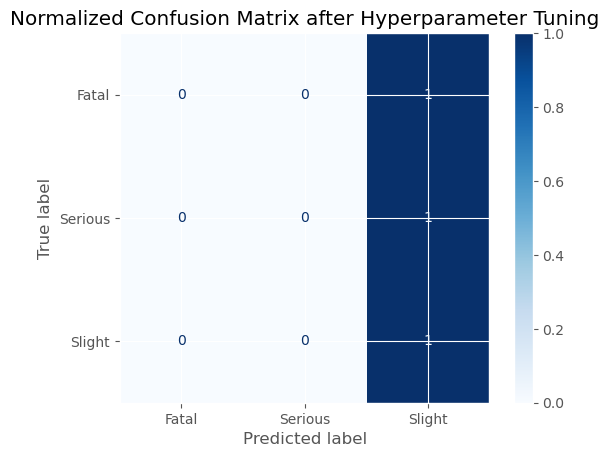

In [59]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import GridSearchCV

# Stratified KFold Cross-validation to ensure proportional representation from all classes
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model definition (Random Forest)
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight=None,  # Use class_weight='balanced' if you need automatic balancing
    max_depth=10, 
    min_samples_split=2, 
    min_samples_leaf=4
)

# Cross-validation with StratifiedKFold
cv_results = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print(f"📊 Cross-validation results (Accuracy): {cv_results}")
print(f"📈 Mean CV Accuracy: {cv_results.mean():.4f}")

# Hyperparameter tuning with GridSearchCV for better performance
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Using GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Best Parameters
print("🔑 Best Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Best model from grid search
best_model = grid_search.best_estimator_

# Evaluate with the best model
y_pred_best = best_model.predict(X_test)

# Classification report for the best model
print("🔍 Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# Normalized Confusion Matrix for the best model
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best, 
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix after Hyperparameter Tuning')
plt.show()


🔍 Classification Report for RandomForest with Balanced Weights:
              precision    recall  f1-score   support

       Fatal     0.0083    0.1667    0.0158        30
     Serious     0.1750    0.7924    0.2867      1050
      Slight     0.9243    0.2423    0.3839      5795

    accuracy                         0.3260      6875
   macro avg     0.3692    0.4004    0.2288      6875
weighted avg     0.8059    0.3260    0.3675      6875



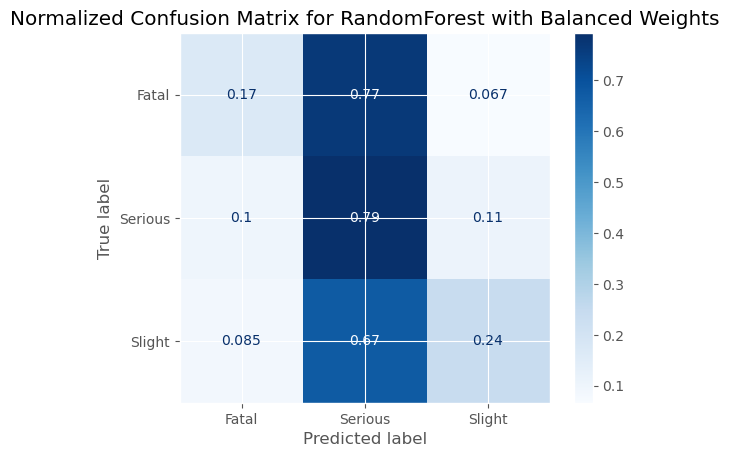

In [60]:
# Using class_weight='balanced' to deal with imbalance
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',  # Use balanced class weights
    random_state=42
)

# Train the model with cross-validation
model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = model.predict(X_test)

# Classification report for RandomForest with class_weight='balanced'
print("🔍 Classification Report for RandomForest with Balanced Weights:")
print(classification_report(y_test, y_pred_rf, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# Normalized Confusion Matrix for RandomForest
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, 
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix for RandomForest with Balanced Weights')
plt.show()


c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 16039, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

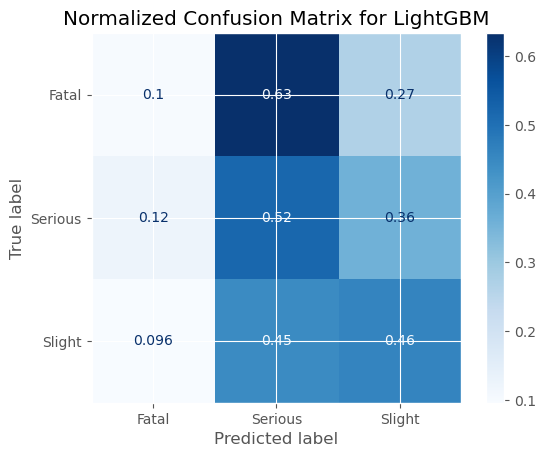

In [ ]:

import lightgbm as lgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Initialize LightGBM model
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Use balanced class weights
    random_state=42
)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict using the trained model
y_pred_lgbm = lgbm_model.predict(X_test)

# Classification report for LightGBM
print("🔍 Classification Report for LightGBM:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# Normalized Confusion Matrix for LightGBM
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lgbm, 
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix for LightGBM')
plt.show()


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 16039, number of used features: 18
[LightGBM] [Info] Start training from score -5.420099
[LightGBM] [Info] Start training from score -1.879343
[LightGBM] [Info] Start training from score -0.170927
[LightGBM] 

c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


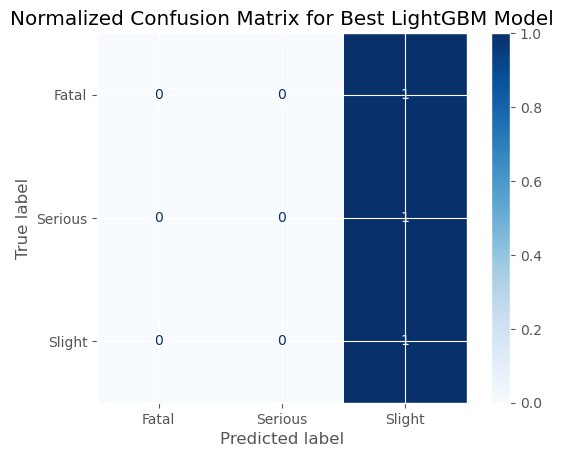

In [63]:
# Fine-tuning LightGBM hyperparameters
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None],
    'learning_rate': [0.05, 0.1, 0.2],
}

# Create the model
lgbm = lgb.LGBMClassifier(random_state=42)

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters found by grid search
print("🔑 Best Hyperparameters found by GridSearchCV:", grid_search.best_params_)

# Evaluate the best model
best_lgbm = grid_search.best_estimator_
y_pred_best_lgbm = best_lgbm.predict(X_test)

# Classification report for the best LightGBM model
print("🔍 Classification Report for Best LightGBM Model:")
print(classification_report(y_test, y_pred_best_lgbm, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# Normalized Confusion Matrix for Best LightGBM Model
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best_lgbm, 
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix for Best LightGBM Model')
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 16039, number of used features: 18
[LightGBM] [Info] Start training from score -5.420099
[LightGBM] [Info] Start training from score -1.879343
[LightGBM] [Info] Start training from score -0.170927
🔍 Classification Report for Voting Classifier:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.1870    0.0219    0.0392      1050
      Slight     0.8436    0.9821    0.9076      5795

    accuracy                         0.8311      6875
   macro avg     0.3435    0.3347    0.3156      6875
weighted avg     0.7396    0.8311    0.7710      6875



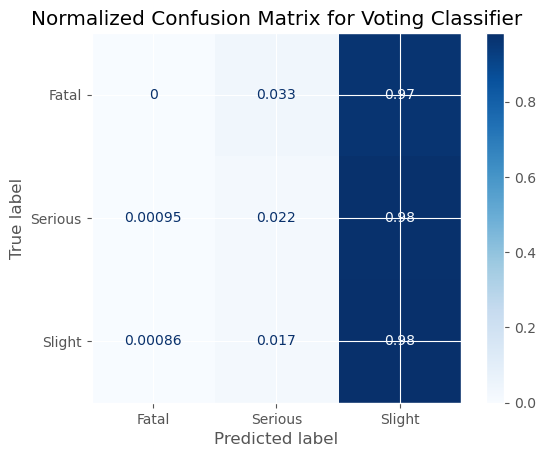

In [64]:
from sklearn.ensemble import VotingClassifier

# Define models for the ensemble
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Combine models into a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('lgbm', lgbm_model)
], voting='soft')  # 'soft' voting gives weighted predictions

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred_voting = voting_clf.predict(X_test)

# Classification report for ensemble model
print("🔍 Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting, target_names=['Fatal', 'Serious', 'Slight'], digits=4))

# Normalized Confusion Matrix for Voting Classifier
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_voting, 
    normalize='true',
    display_labels=['Fatal', 'Serious', 'Slight'],
    cmap='Blues'
)
plt.title('Normalized Confusion Matrix for Voting Classifier')
plt.show()


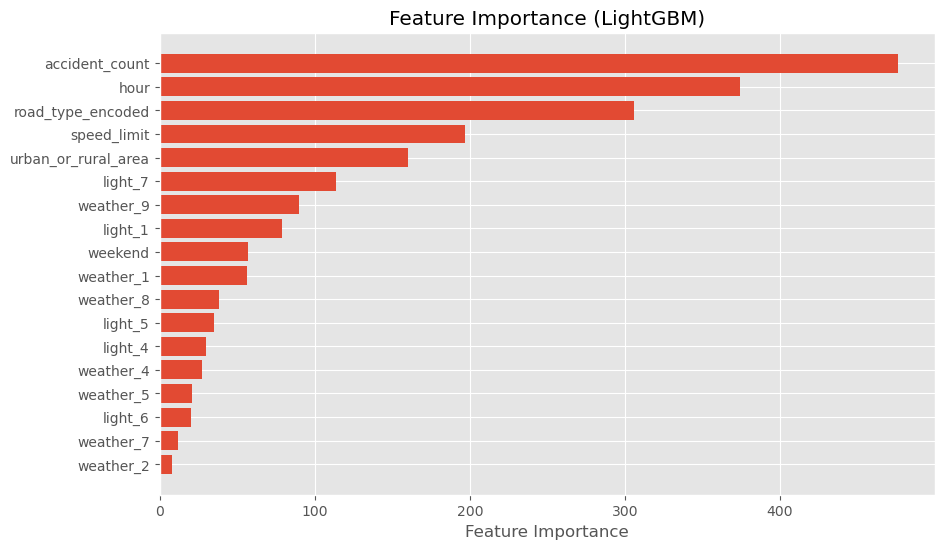

In [65]:
# Feature importance for LightGBM model
importances = best_lgbm.feature_importances_

# Sort features by importance
indices = importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importance (LightGBM)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()


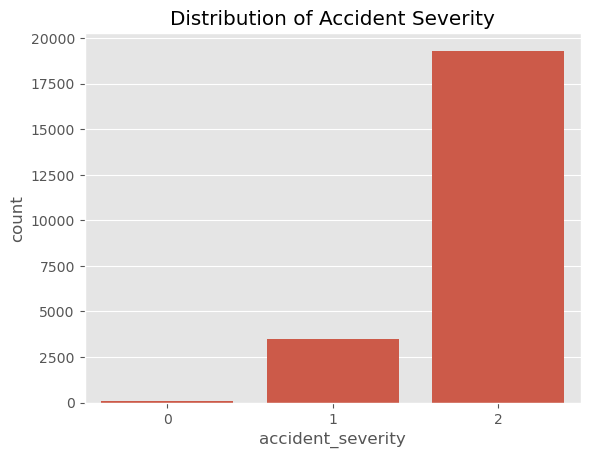

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check distribution of accident severity classes
sns.countplot(x='accident_severity', data=merged_gdf)
plt.title('Distribution of Accident Severity')
plt.show()


In [67]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the dataset
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Train the classifier again with resampled data
best_lgbm.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred_resampled = best_lgbm.predict(X_test)

# Classification report after ADASYN
print("🔍 Classification Report after ADASYN:")
print(classification_report(y_test, y_pred_resampled, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 29480, number of used features: 18
[LightGBM] [Info] Start training from score -0.780134
[LightGBM] [Info] Start training from score -2.488032
[LightGBM] [Info] Start training from score -0.779616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
# Example of threshold adjustment
y_prob = best_lgbm.predict_proba(X_test)

# Adjusting the threshold for predicting the "Fatal" class
threshold = 0.25  # For example, setting a lower threshold for Fatal accidents
y_pred_adjusted = (y_prob[:, 0] >= threshold).astype(int)  # Assuming index 0 is Fatal

# Classification report with adjusted threshold
print("🔍 Classification Report after Threshold Adjustment:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
🔍 Classification Report after Threshold Adjustment:
              precision    recall  f1-score   support

       Fatal     0.0043    0.7333    0.0086        30
     Serious     0.1872    0.3229    0.2370      1050
      Slight     0.0000    0.0000    0.0000      5795

    accuracy                         0.0525      6875
   macro avg     0.0638    0.3521    0.0819      6875
weighted avg     0.0286    0.0525    0.0362      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
from xgboost import XGBClassifier

# Initialize and train the XGBoost model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluate the XGBoost model
y_pred_xgb = xgb.predict(X_test)

# Classification report for XGBoost
print("🔍 Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


🔍 Classification Report for XGBoost:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.3519    0.0181    0.0344      1050
      Slight     0.8446    0.9941    0.9133      5795

    accuracy                         0.8407      6875
   macro avg     0.3988    0.3374    0.3159      6875
weighted avg     0.7657    0.8407    0.7751      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the dataset
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Train the classifier again with the resampled data
best_model.fit(X_resampled, y_resampled)

# Evaluate the model again
y_pred_resampled = best_model.predict(X_test)

# Classification report after ADASYN
print("🔍 Classification Report after ADASYN:")
print(classification_report(y_test, y_pred_resampled, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


🔍 Classification Report after ADASYN:
              precision    recall  f1-score   support

       Fatal     0.0059    0.2000    0.0115        30
     Serious     0.0000    0.0000    0.0000      1050
      Slight     0.8514    0.8609    0.8561      5795

    accuracy                         0.7265      6875
   macro avg     0.2858    0.3536    0.2892      6875
weighted avg     0.7176    0.7265    0.7217      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [71]:
# Example of threshold adjustment for a more sensitive prediction for Fatal accidents
y_prob = best_model.predict_proba(X_test)

# Adjusting the threshold for predicting "Fatal" class (index 0 for Fatal in this case)
threshold = 0.25  # Lower threshold for better detection of Fatal accidents
y_pred_adjusted = (y_prob[:, 0] >= threshold).astype(int)

# Classification report with adjusted threshold
print("🔍 Classification Report after Threshold Adjustment:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


🔍 Classification Report after Threshold Adjustment:
              precision    recall  f1-score   support

       Fatal     0.0033    0.3333    0.0065        30
     Serious     0.1702    0.6238    0.2674      1050
      Slight     0.0000    0.0000    0.0000      5795

    accuracy                         0.0967      6875
   macro avg     0.0578    0.3190    0.0913      6875
weighted avg     0.0260    0.0967    0.0409      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [72]:
from xgboost import XGBClassifier

# Initialize XGBoost with default parameters
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model with the original or rebalanced data
xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test)

# Classification report for XGBoost
print("🔍 Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


🔍 Classification Report for XGBoost:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.3519    0.0181    0.0344      1050
      Slight     0.8446    0.9941    0.9133      5795

    accuracy                         0.8407      6875
   macro avg     0.3988    0.3374    0.3159      6875
weighted avg     0.7657    0.8407    0.7751      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Set up hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_dist, n_iter=50, cv=3, random_state=42)
random_search.fit(X_train, y_train)

# Best hyperparameters
print("🔑 Best Hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

# Evaluate the best model
best_xgb = random_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

# Classification report for the best XGBoost model
print("🔍 Classification Report for Best XGBoost Model:")
print(classification_report(y_test, y_pred_best_xgb, target_names=['Fatal', 'Serious', 'Slight'], digits=4))


🔑 Best Hyperparameters found by RandomizedSearchCV:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
🔍 Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000        30
     Serious     0.0000    0.0000    0.0000      1050
      Slight     0.8429    1.0000    0.9148      5795

    accuracy                         0.8429      6875
   macro avg     0.2810    0.3333    0.3049      6875
weighted avg     0.7105    0.8429    0.7711      6875



c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Idris\anaconda3\envs\sds2024\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
from sklearn.model_selection import cross_val_score

# Evaluate model using cross-validation (F1-score is important for imbalanced classes)
cv_results = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='f1_weighted')

# Print the cross-validation results
print(f"Cross-validation results (F1-score): {cv_results}")
print(f"Mean F1-score: {cv_results.mean()}")


Cross-validation results (F1-score): [0.77103587 0.77103587 0.77103587 0.77103587 0.77096675]
Mean F1-score: 0.7710220488202983


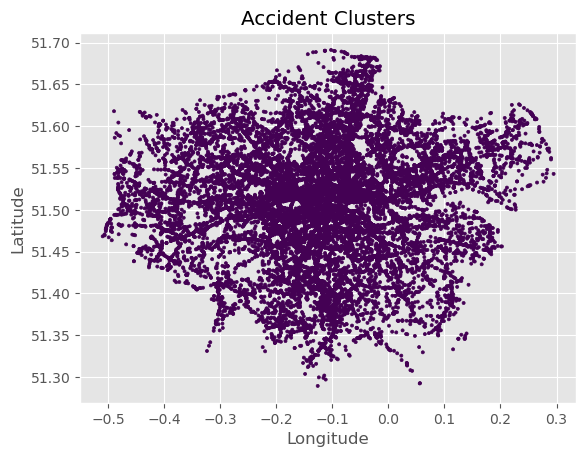

In [78]:
from sklearn.cluster import DBSCAN
import numpy as np

# Use DBSCAN (Density-Based Spatial Clustering) to find clusters of accidents
coordinates = merged_gdf[['longitude', 'latitude']].values

# Define DBSCAN with a certain radius and minimum samples for clustering
db = DBSCAN(eps=0.01, min_samples=5, metric='haversine')  # eps is in radians (adjust accordingly)
clusters = db.fit_predict(np.radians(coordinates))  # Convert to radians for distance calculation

# Add cluster labels as a new feature to the DataFrame
merged_gdf['cluster'] = clusters

# Visualize the clustering result (optional)
import matplotlib.pyplot as plt
plt.scatter(merged_gdf['longitude'], merged_gdf['latitude'], c=merged_gdf['cluster'], cmap='viridis', s=5)
plt.title('Accident Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


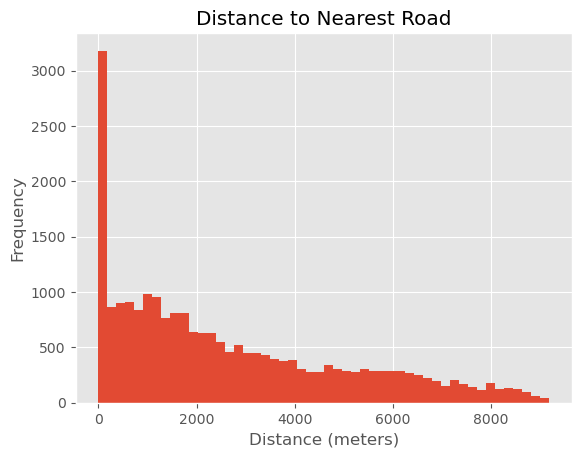

In [81]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Correct path to your shapefile (use raw string format to avoid backslash issues)
shapefile_path = r"C:\Users\Idris\OneDrive - University College London\Documents\CASA 24_25\TERM 2\Data Science for Spatial Systems\Assesement\Accident_Prediction\Data\Shapefiles\Major_Road_Network_2018_Open_Roads\Major_Road_Network_2018_Open_Roads.shp"

# Load road data as a GeoDataFrame
roads_gdf = gpd.read_file(shapefile_path)

# Assuming merged_gdf is your accident data, create a geospatial point from the accident's longitude and latitude
merged_gdf['geometry'] = merged_gdf.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert merged_gdf to GeoDataFrame (if not already done)
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Check if CRS of merged_gdf and roads_gdf match. If not, reproject merged_gdf to match roads_gdf
if merged_gdf.crs != roads_gdf.crs:
    merged_gdf = merged_gdf.to_crs(roads_gdf.crs)

# Calculate distance from each accident to the nearest road
merged_gdf['distance_to_road'] = merged_gdf['geometry'].apply(lambda x: roads_gdf.distance(x).min())

# Plot distance distribution (optional)
merged_gdf['distance_to_road'].hist(bins=50)
plt.title('Distance to Nearest Road')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.show()


In [84]:
# Check columns in the merged_gdf DataFrame
print(merged_gdf.columns)

# Group by 'date' and aggregate accident count and vehicle count (using 'number_of_vehicles')
daily_data = merged_gdf.groupby('date').agg({'accident_count': 'sum', 'number_of_vehicles': 'sum'}).reset_index()

# Check the result
print(daily_data.head())


Index(['accident_index', 'accident_year', 'longitude', 'latitude',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'date', 'day_of_week', 'time', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'light_conditions',
       'weather_conditions', 'road_surface_conditions', 'urban_or_rural_area',
       'lsoa_of_accident_location', 'longitude_missing', 'latitude_missing',
       'weekend', 'day_name', 'time_parsed', 'hour', 'time_bucket',
       'LSOA11CD_x', 'geometry', 'datetime', 'road_type_encoded', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'weather_5', 'weather_6',
       'weather_7', 'weather_8', 'weather_9', 'light_1', 'light_4', 'light_5',
       'light_6', 'light_7', 'LSOA11CD_y', 'accident_count', 'cluster',
       'distance_to_road'],
      dtype='object')
         date  accident_count  number_of_vehicles
0  01/01/2023             373                  60
1  01/02/2023             697                 104
2

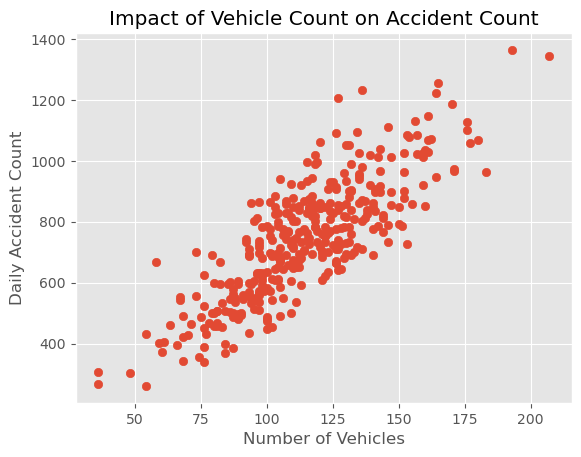

In [85]:
import matplotlib.pyplot as plt

# Analyze vehicle count vs accidents
plt.scatter(daily_data['number_of_vehicles'], daily_data['accident_count'])
plt.xlabel("Number of Vehicles")
plt.ylabel("Daily Accident Count")
plt.title("Impact of Vehicle Count on Accident Count")
plt.show()


    LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   COMESTRES                                   POPDEN  H

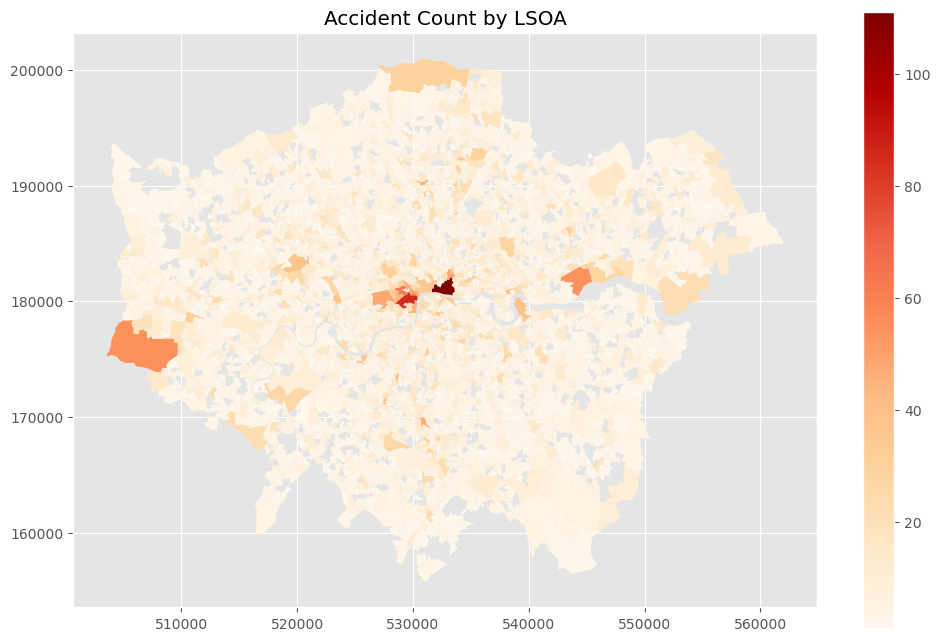

In [92]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct file path to the LSOA shapefile
lsoa_shapefile_path = "C:/Users/Idris/OneDrive - University College London/Documents/CASA 24_25/TERM 2/Data Science for Spatial Systems/Assesement/Accident_Prediction/Data/Shapefiles/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp"

# Load LSOA GeoDataFrame
gdf_lsoa = gpd.read_file(lsoa_shapefile_path)

# Verify the LSOA GeoDataFrame was loaded correctly
print(gdf_lsoa.head())  # Check the first few rows to confirm it's loaded properly

# Aggregate accident data by LSOA
lsoa_summary = merged_gdf.groupby('LSOA11CD_x').agg({
    'accident_index': 'count',  # Count of accidents
    'number_of_casualties': 'sum'  # Sum of casualties
}).reset_index()

# Join aggregated data with LSOA GeoDataFrame on LSOA11CD_x
gdf_lsoa = gdf_lsoa.merge(lsoa_summary, left_on='LSOA11CD', right_on='LSOA11CD_x', how='left')

# Plot accident concentration
gdf_lsoa.plot(column='accident_index', cmap='OrRd', legend=True, figsize=(12, 8))
plt.title('Accident Count by LSOA')
plt.show()



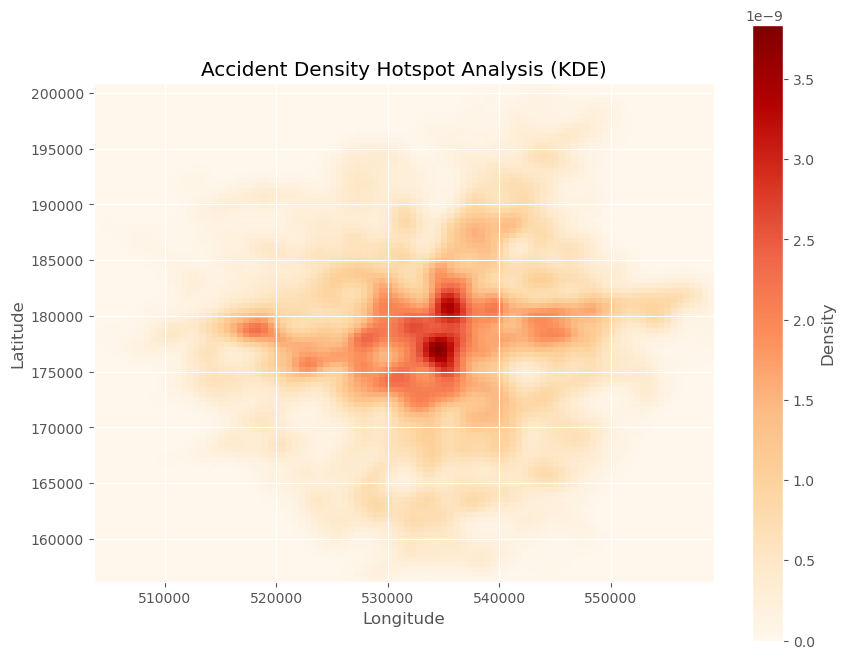

In [93]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming merged_gdf contains accident data with geometry as Points
# Extract the latitude and longitude of accidents
accident_coords = np.array([merged_gdf.geometry.x, merged_gdf.geometry.y])

# Apply Kernel Density Estimation (KDE)
kde = gaussian_kde(accident_coords, bw_method=0.1)
xmin, ymin = merged_gdf.geometry.bounds.minx.min(), merged_gdf.geometry.bounds.miny.min()
xmax, ymax = merged_gdf.geometry.bounds.maxx.max(), merged_gdf.geometry.bounds.maxy.max()

# Create a grid of points where we want to estimate the density
x_grid, y_grid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(grid_coords)

# Reshape the density back to the grid's shape
density = density.reshape(x_grid.shape)

# Plot the KDE result
plt.figure(figsize=(10, 8))
plt.imshow(density, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='OrRd')
plt.colorbar(label='Density')
plt.title("Accident Density Hotspot Analysis (KDE)")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (accident severity)
label_encoder = LabelEncoder()
merged_gdf['accident_severity_encoded'] = label_encoder.fit_transform(merged_gdf['accident_severity'])

# Select features for the model (you can customize this based on the available data)
features = ['number_of_vehicles', 'road_type_encoded', 'weather_conditions', 'speed_limit', 'junction_detail']
X = merged_gdf[features]  # Features
y = merged_gdf['accident_severity_encoded']  # Target variable (accident severity)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance (to understand which features matter most for predicting severity)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))


Accuracy: 0.8487890028365699
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.32      0.02      0.04       652
           2       0.86      0.99      0.92      3911

    accuracy                           0.85      4583
   macro avg       0.39      0.34      0.32      4583
weighted avg       0.78      0.85      0.79      4583

              Feature                               Importance
4     junction_detail                                   0.3193
0  number_of_vehicles                                   0.2273
1   road_type_encoded                                   0.1898
2  weather_conditions                                   0.1404
3         speed_limit                                   0.1232


In [95]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.84027057894134


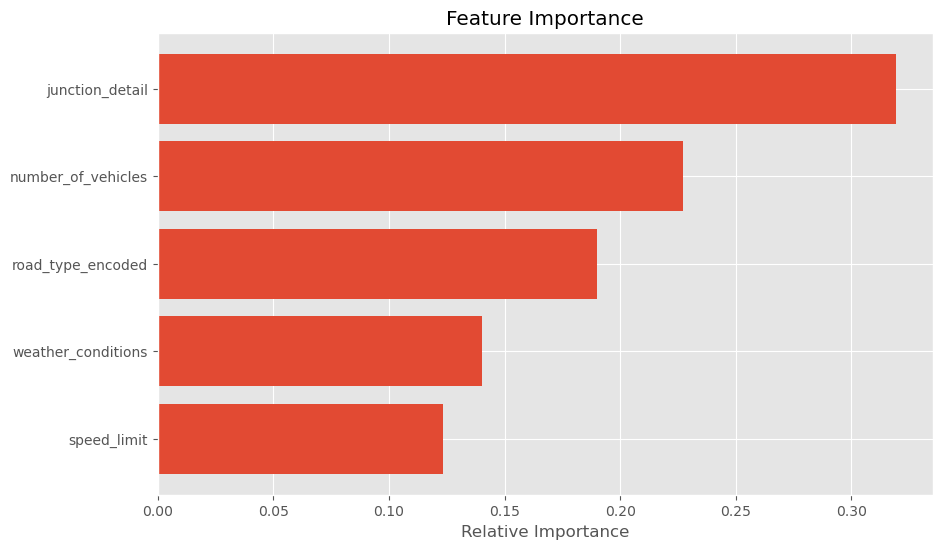

In [96]:
# Plot feature importance
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


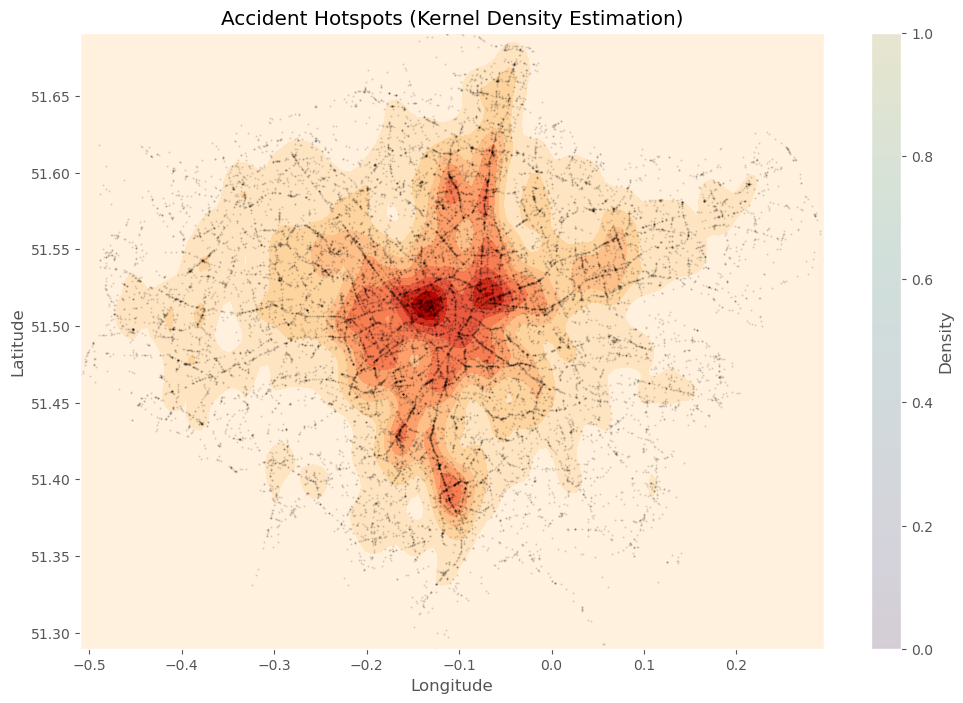

In [97]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import numpy as np

# Ensure merged_gdf has proper geometry
accidents = merged_gdf[['longitude', 'latitude']]
accidents = accidents.dropna()  # Remove rows with missing values

# Convert the data into a format that can be used by KDE
coords = accidents[['longitude', 'latitude']].to_numpy()

# Define the bandwidth (smoothing parameter) for KDE
bandwidth = 0.01  # You can adjust this based on the scale of your dataset

# Apply Kernel Density Estimation (KDE)
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde.fit(coords)

# Create a grid of points where KDE will be evaluated
x_min, x_max = accidents['longitude'].min(), accidents['longitude'].max()
y_min, y_max = accidents['latitude'].min(), accidents['latitude'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_coords = np.vstack([xx.ravel(), yy.ravel()]).T

# Evaluate the density at each point in the grid
density = np.exp(kde.score_samples(grid_coords))

# Reshape the density results back to the grid shape
density = density.reshape(xx.shape)

# Plot the KDE results (hotspots)
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, density, cmap='OrRd', levels=10)
plt.scatter(accidents['longitude'], accidents['latitude'], c='black', s=1, alpha=0.1)  # Plot accidents
plt.colorbar(label='Density')
plt.title('Accident Hotspots (Kernel Density Estimation)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


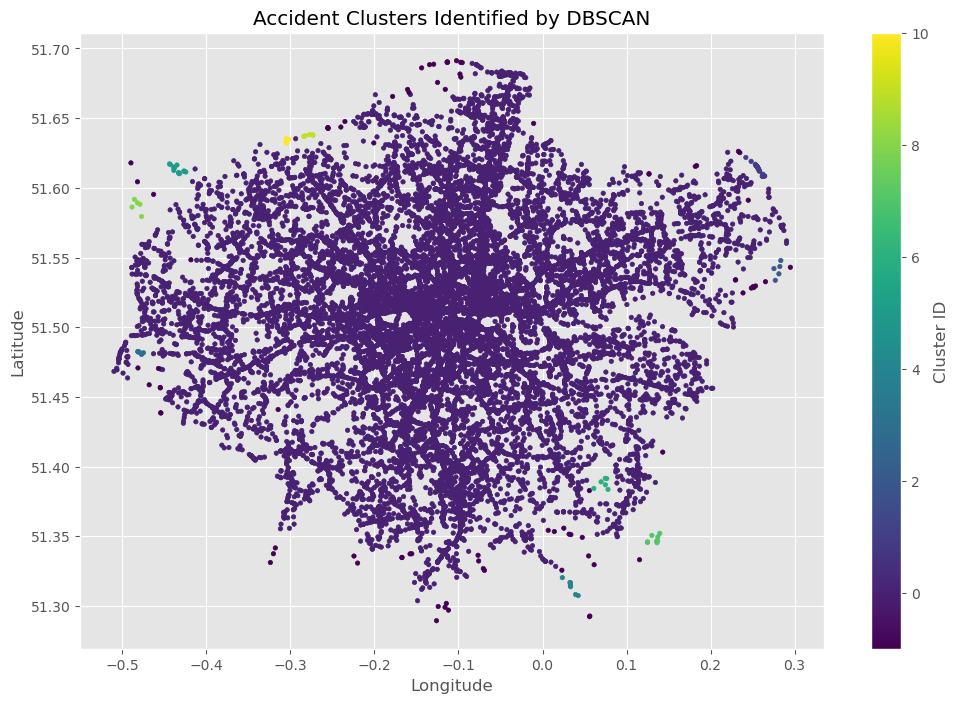

In [98]:
from sklearn.cluster import DBSCAN
import numpy as np

# Prepare data
coords = merged_gdf[['longitude', 'latitude']].dropna().to_numpy()

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.01, min_samples=5)  # eps: distance threshold, min_samples: minimum points to form a cluster
merged_gdf['cluster'] = dbscan.fit_predict(coords)

# Visualize clusters
plt.figure(figsize=(12, 8))
plt.scatter(merged_gdf['longitude'], merged_gdf['latitude'], c=merged_gdf['cluster'], cmap='viridis', s=10)
plt.title('Accident Clusters Identified by DBSCAN')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster ID')
plt.show()


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'merged_gdf' is the dataframe containing the data
# Select your features and target variable
X = merged_gdf[['hour', 'day_of_week', 'weather_conditions', 'road_type', 'speed_limit', 'number_of_vehicles', 'distance_to_road']]  # Features
y = merged_gdf['accident_count']  # Target variable (accident count or severity)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale the features (important for some models, not necessary for decision tree, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = dt_regressor.predict(X_test_scaled)

# Evaluate the model
print("Decision Tree Regressor Evaluation:")
print("R² on the training data:", dt_regressor.score(X_train_scaled, y_train))
print("R² on the testing data:", dt_regressor.score(X_test_scaled, y_test))

# Mean Squared Error
mse_dt = mean_squared_error(y_test, y_pred_dt)
print("Mean Squared Error (Decision Tree):", mse_dt)

# Feature Importance
print("Feature Importance (Decision Tree):")
feature_importance_dt = pd.Series(dt_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance_dt)


Decision Tree Regressor Evaluation:
R² on the training data: 1.0
R² on the testing data: -0.8652997501933135
Mean Squared Error (Decision Tree): 286.3807549639974
Feature Importance (Decision Tree):
distance_to_road                                       0.5517
hour                                                   0.1822
day_of_week                                            0.1139
road_type                                              0.0523
weather_conditions                                     0.0414
number_of_vehicles                                     0.0356
speed_limit                                            0.0229
dtype: float64


In [105]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Regressor Evaluation:")
print("R² on the training data:", rf_regressor.score(X_train_scaled, y_train))
print("R² on the testing data:", rf_regressor.score(X_test_scaled, y_test))

# Mean Squared Error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error (Random Forest):", mse_rf)

# Feature Importance
print("Feature Importance (Random Forest):")
feature_importance_rf = pd.Series(rf_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance_rf)


Random Forest Regressor Evaluation:
R² on the training data: 0.8647031749005162
R² on the testing data: 0.03627236699186742
Mean Squared Error (Random Forest): 147.96176705214924
Feature Importance (Random Forest):
distance_to_road                                       0.5577
hour                                                   0.1695
day_of_week                                            0.1080
road_type                                              0.0570
weather_conditions                                     0.0461
number_of_vehicles                                     0.0344
speed_limit                                            0.0273
dtype: float64


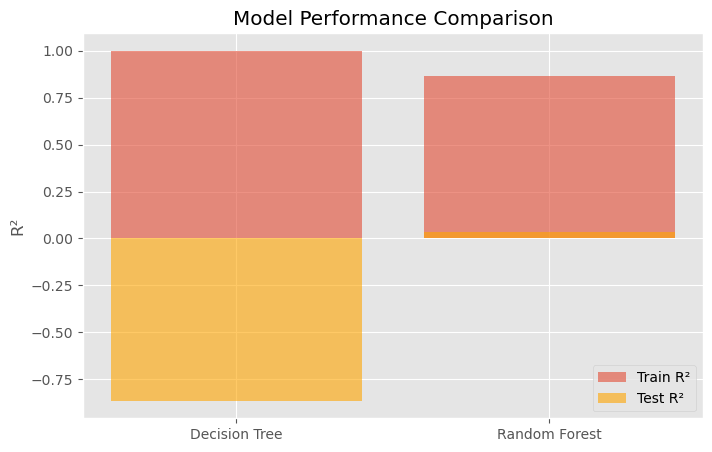

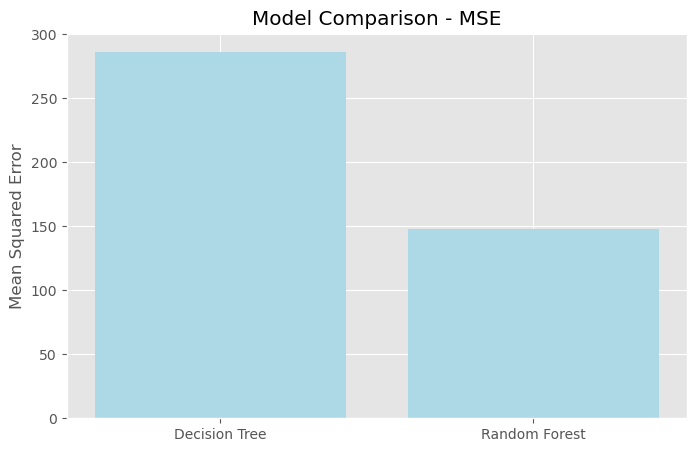

In [106]:
import matplotlib.pyplot as plt

# Plot R² for both models
models = ['Decision Tree', 'Random Forest']
train_scores = [dt_regressor.score(X_train_scaled, y_train), rf_regressor.score(X_train_scaled, y_train)]
test_scores = [dt_regressor.score(X_test_scaled, y_test), rf_regressor.score(X_test_scaled, y_test)]

plt.figure(figsize=(8, 5))
plt.bar(models, train_scores, alpha=0.6, label='Train R²')
plt.bar(models, test_scores, alpha=0.6, label='Test R²', color='orange')
plt.ylabel('R²')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

# Plot Mean Squared Error for both models
plt.figure(figsize=(8, 5))
plt.bar(models, [mse_dt, mse_rf], color='lightblue')
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison - MSE')
plt.show()
